## Seguimiento 2: Construcción y Análisis de Red de Artículos Científicos

Este notebook implementa un grafo dirigido ponderado que representa relaciones entre artículos científicos basadas en similitud semántica, keywords compartidas y co-autoría.

### Objetivos:
1. Cargar datos de archivo BibTeX
2. Crear nodos con información de artículos
3. Calcular similitud con SBERT (embeddings semánticos)
4. Construir aristas con reglas multi-criterio
5. Filtrar componentes para mantener red conexa
6. Visualizar grafo con NetworkX
7. Aplicar algoritmos de grafos (Dijkstra, Kosaraju)

### Flujo del Proceso:
```
Carga BibTeX → Creación de Nodos → Preprocesamiento → 
Embeddings SBERT → Cálculo de Similitud → Reglas de Aristas → 
Construcción de Grafo → Filtrado de Componentes → 
Visualización → Algoritmos de Grafos
```

### Características del Grafo:

#### Tipo de Grafo:
- **Dirigido**: Las relaciones tienen dirección (A → B)
- **Ponderado**: Cada arista tiene un peso (similitud + keywords + autores)
- **Conexo**: Se mantiene solo el componente más grande

#### Criterios de Conexión:

**Reglas estrictas** (todas deben cumplirse):
1. **Similitud SBERT** > 0.5 (similitud semántica de títulos)
2. **Keywords compartidas** ≥ 2 (mínimo 2 palabras clave comunes)
3. **Autores compartidos** ≥ 1 (mínimo 1 autor en común)

**Peso de arista**:
```python
peso = similitud_sbert + num_keywords_comunes + num_autores_comunes
```

### Algoritmos Implementados:

#### 1. Dijkstra (Caminos Mínimos):
- Encuentra la ruta más corta entre dos artículos
- Respeta dirección de aristas
- Complejidad: O((V + E) log V)

#### 2. Kosaraju (Componentes Fuertemente Conexos):
- Identifica clusters de artículos fuertemente relacionados
- Dos DFS: normal + grafo invertido
- Complejidad: O(V + E)

### Tecnologías Utilizadas:
- **bibtexparser**: Lectura de archivos BibTeX
- **sentence-transformers**: Embeddings semánticos (SBERT)
- **NetworkX**: Construcción y análisis de grafos
- **Matplotlib**: Visualización
- **heapq**: Implementación eficiente de Dijkstra
- **NumPy**: Operaciones matriciales

### Métricas del Grafo:
- Número de nodos
- Número de aristas
- Componentes conexas
- Caminos mínimos
- Componentes fuertemente conexos

### Paso 1: Carga de Datos BibTeX

Esta celda carga el archivo BibTeX y extrae campos clave de cada artículo.

## Proceso de Carga

### Lectura del Archivo:

```python
with open(archivo_bib, encoding="utf-8") as bibtex_file:
    bib_database = bibtexparser.load(bibtex_file)
```

**Parámetros**:
- `encoding="utf-8"`: Soporte para caracteres especiales
- `bibtexparser.load()`: Parser especializado para BibTeX

### Extracción de Campos:

```python
articulo = {
    "title": art.get("title", ""),
    "author": art.get("author", ""),
    "keywords": art.get("keywords", ""),
    "year": art.get("year", "")
}
```

#### Campos Extraídos:

| Campo | Descripción | Uso en el Grafo |
|-------|-------------|-----------------|
| **title** | Título del artículo | Similitud semántica (SBERT) |
| **author** | Lista de autores | Detección de co-autoría |
| **keywords** | Palabras clave | Similitud temática |
| **year** | Año de publicación | Metadata del nodo |

**Método `.get()`**: Retorna string vacío si el campo no existe (evita errores)

## Formato de Autores en BibTeX:

**Entrada típica**:
```
author = {Smith, John and Doe, Jane and Johnson, Bob}
```

**Características**:
- Separador: ` and ` (con espacios)
- Formato: `Apellido, Nombre`
- Múltiples autores en un solo string

### Formato de Keywords:

**Entrada típica**:
```
keywords = {Machine Learning;Deep Learning;Neural Networks}
```

**Características**:
- Separador: `;` (punto y coma)
- A veces también `,` (coma)
- Pueden tener espacios extra

In [1]:
import bibtexparser
import os
from dotenv import load_dotenv

# Cargar variables de entorno
load_dotenv()

# Obtener ruta del archivo desde variable de entorno
archivo_bib = os.getenv("PRIMEROS_500", "primeros_500.bib")

# Verificar que el archivo existe
if not os.path.exists(archivo_bib):
    print(f"Error: No se encuentra el archivo en {archivo_bib}")
    raise FileNotFoundError(f"No se encuentra {archivo_bib}")

print(f"Leyendo archivo: {archivo_bib}")

# Cargar el archivo BibTeX
with open(archivo_bib, encoding="utf-8") as bibtex_file:
    bib_database = bibtexparser.load(bibtex_file)

entries = bib_database.entries
print("Número de artículos cargados:", len(entries))

articulos = []
for art in entries:
    articulo = {
        "title": art.get("title", ""),
        "author": art.get("author", ""),
        "keywords": art.get("keywords", ""),
        "year": art.get("year", "")
    }
    articulos.append(articulo)

# Mostrar los primeros 5 artículos para verificar
articulos[:5]

Leyendo archivo: /home/nop/Documentos/proyectoAnalisisAlgoritmos/proyecto/primeros_500.bib
Número de artículos cargados: 500


[{'title': 'Do Robots Dream of Passing a Programming Course?',
  'author': 'Torres, Nicolás',
  'keywords': 'Training;Computational modeling;Instruments;Natural languages;Learning (artificial intelligence);Syntactics;Task analysis;Artificial Intelligence;Neural Networks;Programming;Learning Analysis;Technology-Enhanced Learning',
  'year': '2023'},
 {'title': "WeAIR: Wearable Swarm Sensors for Air Quality Monitoring to Foster Citizens' Awareness of Climate Change",
  'author': 'Dimitri, Giovanna Maria and Parri, Lorenzo and Pozzebon, Alessandro and Vitanza, Eleonora and Fort, Ada and Mocenni, Chiara',
  'keywords': "Temperature measurement;Climate change;Cloud computing;Pollution measurement;Reliability;Artificial intelligence;Wearable sensors;climate change;air quality;monitoring devices;health;citizens' science",
  'year': '2023'},
 {'title': 'Discriminative-Generative Representation Learning for One-Class Anomaly Detection',
  'author': 'Li, Duanjiao and Chen, Yun and Zhang, Ying an

### Paso 2: Creación de Nodos del Grafo

Esta celda convierte cada artículo en un nodo del grafo con su información asociada.

## Estructura de Nodos

### Diccionario de Nodos:

```python
nodos = {
    id_nodo: {
        "title": "...",
        "author": "...",
        "keywords": "...",
        "year": "..."
    },
    ...
}
```

**Estructura**:
- **Clave**: ID único del nodo
- **Valor**: Diccionario con información del artículo

## Identificadores de Nodos

### Estrategia de ID:

```python
id_nodo = art.get("doi", f"Articulo_{idx}")
```

#### Prioridad:

1. **DOI** (si existe): Identificador único internacional
2. **Índice** (fallback): Identificador secuencial

### Ventajas de Usar DOI:

| Aspecto | DOI | Índice |
|---------|-----|--------|
| **Unicidad** | Global | Local |
| **Persistencia** | Permanente | Cambia con orden |
| **Trazabilidad** | Verificable | No verificable |
| **Interoperabilidad** | Estándar | Específico |

In [2]:
# %% Crear nodos del grafo
# Usaremos un diccionario para representar cada nodo: {id_nodo: info_articulo}

nodos = {}

for idx, art in enumerate(articulos):
    # Identificador del nodo: DOI si existe, si no el índice
    id_nodo = art.get("doi", f"Articulo_{idx}")
    
    # Información básica del nodo
    nodos[id_nodo] = {
        "title": art["title"],
        "author": art["author"],
        "keywords": art["keywords"],
        "year": art["year"]
    }

# Mostrar los primeros 5 nodos para verificar
list(nodos.items())[:5]


[('Articulo_0',
  {'title': 'Do Robots Dream of Passing a Programming Course?',
   'author': 'Torres, Nicolás',
   'keywords': 'Training;Computational modeling;Instruments;Natural languages;Learning (artificial intelligence);Syntactics;Task analysis;Artificial Intelligence;Neural Networks;Programming;Learning Analysis;Technology-Enhanced Learning',
   'year': '2023'}),
 ('Articulo_1',
  {'title': "WeAIR: Wearable Swarm Sensors for Air Quality Monitoring to Foster Citizens' Awareness of Climate Change",
   'author': 'Dimitri, Giovanna Maria and Parri, Lorenzo and Pozzebon, Alessandro and Vitanza, Eleonora and Fort, Ada and Mocenni, Chiara',
   'keywords': "Temperature measurement;Climate change;Cloud computing;Pollution measurement;Reliability;Artificial intelligence;Wearable sensors;climate change;air quality;monitoring devices;health;citizens' science",
   'year': '2023'}),
 ('Articulo_2',
  {'title': 'Discriminative-Generative Representation Learning for One-Class Anomaly Detection',

### Paso 3: Preprocesamiento y Cálculo de Similitud con SBERT

Esta celda preprocesa los datos y calcula la similitud semántica entre artículos usando embeddings de SBERT.

## Parte 1: Preprocesamiento de Nodos

### Normalización de Autores:

```python
parts = re.split(r'\s+and\s+|,|;|\\\\|\\', authors, flags=re.IGNORECASE)
info['author_list'] = [a.strip().lower() for a in parts if a and a.strip()]
```

#### Regex de Separación:

**Patrón**: `r'\s+and\s+|,|;|\\\\|\\'`

**Significado**:
- `\s+and\s+`: Palabra "and" con espacios (case-insensitive)
- `,`: Coma
- `;`: Punto y coma
- `\\\\`: Doble backslash
- `\\`: Backslash simple

### Normalización de Keywords:

```python
kws = re.split(r';|,', keywords)
info['keywords_list'] = [k.strip().lower() for k in kws if k and k.strip()]
```

### Normalización de Títulos:

```python
info['title_text'] = title.strip().lower()
```

**Propósito**: Texto limpio para embeddings de SBERT

## Parte 2: Embeddings con SBERT

### Modelo Utilizado:

```python
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')
```

#### Características del Modelo:

| Aspecto | Valor |
|---------|-------|
| **Nombre** | all-MiniLM-L6-v2 |
| **Dimensiones** | 384 |
| **Tamaño** | 22.7 MB |
| **Velocidad** | ~3,000 oraciones/seg (GPU) |
| **Calidad** | Excelente para uso general |

### Generación de Embeddings:

```python
prueba_embeddings = model.encode(
    prueba_titulos, 
    convert_to_tensor=True, 
    batch_size=64, 
    show_progress_bar=True
)
```

#### Parámetros:

**`convert_to_tensor=True`**:
- Retorna tensores de PyTorch
- Más eficiente para cálculos matriciales

**`batch_size=64`**:
- Procesa 64 títulos a la vez
- Balance entre velocidad y memoria

**`show_progress_bar=True`**:
- Muestra barra de progreso
- Útil para datasets grandes

## Parte 3: Matriz de Similitud

### Cálculo de Similitud del Coseno:

```python
prueba_sim_matrix = util.pytorch_cos_sim(
    prueba_embeddings, 
    prueba_embeddings
).cpu().numpy()
```

#### Similitud del Coseno:

**Fórmula**:
```
cos(θ) = (A · B) / (||A|| × ||B||)
```

**Rango**: [-1, 1]
- **1.0**: Vectores idénticos (títulos muy similares)
- **0.0**: Vectores ortogonales (sin relación)
- **-1.0**: Vectores opuestos (raro en textos)

## Parte 4: Creación de Aristas

### Reglas Multi-Criterio:

```python
if (sbert_sim > umbral_sbert and 
    len(keywords_comunes) >= min_shared_keywords and 
    len(autores_comunes) >= min_shared_authors):
    
    peso = sbert_sim + len(keywords_comunes) + len(autores_comunes)
    prueba_aristas[(id_i, id_j)] = peso
```

#### Umbrales Configurables:

| Criterio | Umbral | Justificación |
|----------|--------|---------------|
| **SBERT** | > 0.5 | Similitud semántica moderada-alta |
| **Keywords** | ≥ 2 | Al menos 2 temas comunes |
| **Autores** | ≥ 1 | Al menos 1 co-autor |

### Cálculo de Peso:

**Fórmula**:
```python
peso = similitud_sbert + num_keywords + num_autores
```

**Interpretación**: Mayor peso = relación más fuerte

In [3]:
# --- Preprocesar nodos: listas de autores, keywords y título en minúscula (más robusto) ---
import re
for nodo_id, info in nodos.items():
    # Usar .get para evitar errores si faltan campos
    authors = info.get('author', '') or ''
    keywords = info.get('keywords', '') or ''
    title = info.get('title', '') or ''

    # Normalizar y dividir autores: separar por ' and ', comas o ';' (ignorando mayúsculas)
    parts = re.split(r'\s+and\s+|,|;|\\\\|\\', authors, flags=re.IGNORECASE)
    info['author_list'] = [a.strip().lower() for a in parts if a and a.strip()]

    # Normalizar y dividir keywords por ';' o ','
    kws = re.split(r';|,', keywords)
    info['keywords_list'] = [k.strip().lower() for k in kws if k and k.strip()]

    # Título en minúscula (texto limpio)
    info['title_text'] = title.strip().lower()

# --- Tomar los primeros 1000 nodos (o menos si no hay) para construir el grafo ---
max_nodos = 1000
prueba_nodos_ids = list(nodos.keys())[:max_nodos]
prueba_titulos = [nodos[n]['title_text'] for n in prueba_nodos_ids]

# --- Cargar modelo SBERT ---
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-MiniLM-L6-v2')

# --- Obtener embeddings de la muestra ---
prueba_embeddings = model.encode(prueba_titulos, convert_to_tensor=True, batch_size=64, show_progress_bar=True)

# --- Matriz de similitud de prueba (coseno) ---
prueba_sim_matrix = util.pytorch_cos_sim(prueba_embeddings, prueba_embeddings).cpu().numpy()

# --- Crear diccionario de aristas dirigidas según reglas (iterar todas las parejas ordenadas):
# Si la regla es simétrica (como similitud+keywords+authors), iterar todas las parejas permite crear aristas i->j y j->i cuando corresponda.
prueba_aristas = {}
# Umbrales (ajusta si quieres más estrictez)
umbral_sbert = 0.5
min_shared_keywords = 2
min_shared_authors = 1
N = len(prueba_nodos_ids)

for i in range(N):
    for j in range(N):
        if i == j:
            continue
        id_i = prueba_nodos_ids[i]
        id_j = prueba_nodos_ids[j]
        info1 = nodos[id_i]
        info2 = nodos[id_j]

        # Coincidencias (ya están en minúscula)
        autores_comunes = set(info1.get('author_list', [])) & set(info2.get('author_list', []))
        keywords_comunes = set(info1.get('keywords_list', [])) & set(info2.get('keywords_list', []))

        # Similitud de títulos (i->j usa matriz[i,j])
        sbert_sim = float(prueba_sim_matrix[i, j])

        # Aplicar las reglas estrictas: si se cumplen, añadimos la arista dirigida i -> j
        if sbert_sim > umbral_sbert and len(keywords_comunes) >= min_shared_keywords and len(autores_comunes) >= min_shared_authors:
            # Peso: combinación simple (puedes ajustar ponderadores)
            peso = sbert_sim + len(keywords_comunes) + len(autores_comunes)
            prueba_aristas[(id_i, id_j)] = peso

# --- Ver algunas aristas de prueba y estadísticas ---
print('Nodos considerados (N)=', N)
print('Número de aristas creadas (dir):', len(prueba_aristas))
# mostrar algunas aristas
list(prueba_aristas.items())[:10]


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Nodos considerados (N)= 500
Número de aristas creadas (dir): 134


[(('Articulo_2', 'Articulo_171'), 3.512347638607025),
 (('Articulo_2', 'Articulo_345'), 4.588215470314026),
 (('Articulo_2', 'Articulo_427'), 4.547263145446777),
 (('Articulo_2', 'Articulo_431'), 4.557884991168976),
 (('Articulo_12', 'Articulo_47'), 4.547934293746948),
 (('Articulo_16', 'Articulo_328'), 4.523435413837433),
 (('Articulo_17', 'Articulo_198'), 3.618647575378418),
 (('Articulo_18', 'Articulo_423'), 4.5104286670684814),
 (('Articulo_30', 'Articulo_186'), 4.651097357273102),
 (('Articulo_30', 'Articulo_345'), 4.5617746114730835)]

# Paso 4: Construcción del Grafo con NetworkX

Esta celda construye el grafo dirigido usando NetworkX y filtra componentes pequeños.

## Construcción del Grafo

### Crear Grafo Dirigido:

```python
G = nx.DiGraph()
```

**Tipo**: `DiGraph` (Directed Graph)
- Aristas tienen dirección (A → B ≠ B → A)
- Permite modelar relaciones asimétricas

### Agregar Nodos con Atributos:

```python
G.add_node(
    nodo_id,
    title=info["title"],
    authors=info.get("author_list", []),
    keywords=info.get("keywords_list", []),
    year=info.get("year", "")
)
```

#### Atributos de Nodos:

| Atributo | Tipo | Uso |
|----------|------|-----|
| **title** | str | Identificación visual |
| **authors** | list | Análisis de co-autoría |
| **keywords** | list | Análisis temático |
| **year** | str | Análisis temporal |

### Agregar Aristas con Peso:

```python
for (origen, destino), peso in prueba_aristas.items():
    if origen in G.nodes() and destino in G.nodes():
        G.add_edge(origen, destino, weight=peso)
```

**Validación**: Verifica que ambos nodos existan antes de agregar arista

## Filtrado de Componentes

### Componentes Débilmente Conexos:

```python
comps = list(nx.weakly_connected_components(G))
```

#### Weakly Connected vs Strongly Connected:

**Weakly Connected** (débilmente conexo):
- Ignora dirección de aristas
- Nodos conectados por cualquier camino
- Más permisivo

**Strongly Connected** (fuertemente conexo):
- Respeta dirección de aristas
- Todos los nodos se alcanzan mutuamente
- Más restrictivo

### Seleccionar Mayor Componente:

```python
comps.sort(key=len, reverse=True)
largest = comps[0]
G = G.subgraph(largest).copy()
```

**Razón del filtrado**:
- Enfocarse en la red principal
- Eliminar nodos aislados
- Facilitar visualización y análisis

## Cálculo de Densidad

### Fórmula:

```
Densidad = Aristas / (Nodos × (Nodos - 1))
```

La densidad aumenta significativamente en el componente principal comparado con el grafo completo.

In [4]:
# Construir el grafo con NetworkX (y limpiar componentes pequeños)
import networkx as nx

# --- Crear grafo dirigido ---
G = nx.DiGraph()

# --- Agregar nodos ---
for nodo_id, info in nodos.items():
    G.add_node(
        nodo_id,
        title=info["title"],
        authors=info.get("author_list", []),
        keywords=info.get("keywords_list", []),
        year=info.get("year", "")
    )

# --- Agregar aristas con peso (si los nodos existen) ---
for (origen, destino), peso in prueba_aristas.items():
    if origen in G.nodes() and destino in G.nodes():
        G.add_edge(origen, destino, weight=peso)

# --- Resumen antes de filtrar componentes ---
print("Antes - Número de nodos:", G.number_of_nodes())
print("Antes - Número de aristas:", G.number_of_edges())

# --- Mantener sólo el componente más grande (weakly connected) ---
if G.number_of_nodes() == 0:
    print("El grafo está vacío, no hay componentes que filtrar.")
else:
    # componentes débiles (ignora dirección). Elegimos la más grande por tamaño
    comps = list(nx.weakly_connected_components(G))
    comps.sort(key=len, reverse=True)
    largest = comps[0]
    print("Número de componentes (weak):", len(comps))
    print("Tamaño del mayor componente (nodos):", len(largest))
    # crear subgrafo con el mayor componente
    G = G.subgraph(largest).copy()
    print("Después - Número de nodos (mayor componente):", G.number_of_nodes())
    print("Después - Número de aristas (mayor componente):", G.number_of_edges())

# --- Ver algunas aristas con pesos (del grafo filtrado) ---
list(G.edges(data=True))[:10]


Antes - Número de nodos: 500
Antes - Número de aristas: 134
Número de componentes (weak): 445
Tamaño del mayor componente (nodos): 21
Después - Número de nodos (mayor componente): 21
Después - Número de aristas (mayor componente): 50


[('Articulo_128', 'Articulo_68', {'weight': 4.593416154384613}),
 ('Articulo_128', 'Articulo_94', {'weight': 5.505793988704681}),
 ('Articulo_128', 'Articulo_99', {'weight': 3.535995304584503}),
 ('Articulo_128', 'Articulo_141', {'weight': 3.5279656052589417}),
 ('Articulo_128', 'Articulo_181', {'weight': 4.528555154800415}),
 ('Articulo_128', 'Articulo_197', {'weight': 3.600160241127014}),
 ('Articulo_128', 'Articulo_198', {'weight': 3.509332597255707}),
 ('Articulo_128', 'Articulo_255', {'weight': 4.611236810684204}),
 ('Articulo_128', 'Articulo_422', {'weight': 3.6297287940979004}),
 ('Articulo_197', 'Articulo_128', {'weight': 3.600160241127014})]

# Paso 5: Visualización del Grafo

Esta celda visualiza un subgrafo del grafo principal usando NetworkX y Matplotlib.

## Proceso de Visualización

### Selección de Nodos:

```python
all_edges = list(G.edges(data=True))
nodes_from_edges = []
M = 200  # Revisar primeras M aristas
for (u, v, _) in all_edges[:M]:
    if u not in nodes_from_edges:
        nodes_from_edges.append(u)
    if v not in nodes_from_edges:
        nodes_from_edges.append(v)
    if len(nodes_from_edges) >= 20:
        break
subgrafo_nodos = nodes_from_edges[:20]
```

**Estrategia**: Tomar nodos de las primeras aristas hasta reunir 20

**Razón**: Visualizar subgrafo manejable

### Crear Subgrafo:

```python
G_sub = G.subgraph(subgrafo_nodos).copy()
```

**Resultado**: Grafo con 20 nodos y sus aristas internas

## Layout del Grafo

### Spring Layout:

```python
pos = nx.spring_layout(G_sub, seed=42)
```

#### Características:

**Algoritmo**: Fruchterman-Reingold
- Simula sistema de fuerzas físicas
- Nodos se repelen (como cargas eléctricas)
- Aristas atraen (como resortes)

**Parámetro `seed=42`**:
- Reproducibilidad
- Mismo layout en cada ejecución

**Alternativas**:
```python
pos = nx.circular_layout(G_sub)  # Circular
pos = nx.kamada_kawai_layout(G_sub)  # Kamada-Kawai
pos = nx.spectral_layout(G_sub)  # Espectral
```

## Elementos Visuales

### Nodos:

```python
nx.draw_networkx_nodes(
    G_sub, pos, 
    node_size=400, 
    node_color='skyblue'
)
```

**Parámetros**:
- `node_size`: Tamaño en puntos
- `node_color`: Color de relleno

### Aristas con Peso:

```python
edges = list(G_sub.edges(data=True))
weights = [d.get('weight', 1.0) for (_, _, d) in edges]

# Normalizar anchuras
min_w, max_w = min(weights), max(weights)
widths = [1.0 + 4.0 * ((w - min_w) / (max_w - min_w)) for w in weights]
```

#### Normalización de Anchuras:

**Fórmula**:
```
width = 1.0 + 4.0 × ((peso - min) / (max - min))
```

**Rango**: [1.0, 5.0]
- Peso mínimo → ancho 1.0
- Peso máximo → ancho 5.0

**Propósito**: Visualizar importancia de conexiones

### Dibujar Aristas:

```python
nx.draw_networkx_edges(
    G_sub, pos,
    edgelist=[(u, v) for (u, v, _) in edges],
    width=widths,
    alpha=0.7,
    edge_color='gray',
    arrows=True,
    arrowsize=18,
    connectionstyle='arc3,rad=0.1'
)
```

#### Parámetros Importantes:

**`arrows=True`**:
- Muestra flechas en aristas dirigidas
- Indica dirección de la relación

**`arrowsize=18`**:
- Tamaño de las puntas de flecha

**`connectionstyle='arc3,rad=0.1'`**:
- Curva las aristas
- `rad=0.1`: Radio de curvatura
- Útil para ver aristas paralelas (A→B y B→A)

**`alpha=0.7`**:
- Transparencia (0=invisible, 1=opaco)
- Permite ver superposiciones

### Etiquetas:

```python
nx.draw_networkx_labels(G_sub, pos, font_size=8)
```

**Contenido**: IDs de nodos

**Alternativa con títulos**:
```python
labels = {n: G_sub.nodes[n]['title'][:20] + '...' 
          for n in G_sub.nodes()}
nx.draw_networkx_labels(G_sub, pos, labels, font_size=6)
```

Nodos elegidos de aristas: ['Articulo_128', 'Articulo_68', 'Articulo_94', 'Articulo_99', 'Articulo_141', 'Articulo_181', 'Articulo_197', 'Articulo_198', 'Articulo_255', 'Articulo_422', 'Articulo_17', 'Articulo_244', 'Articulo_425', 'Articulo_470', 'Articulo_379', 'Articulo_428', 'Articulo_182', 'Articulo_368', 'Articulo_423', 'Articulo_18']
Subgrafo: n_nodos = 20  n_aristas = 46


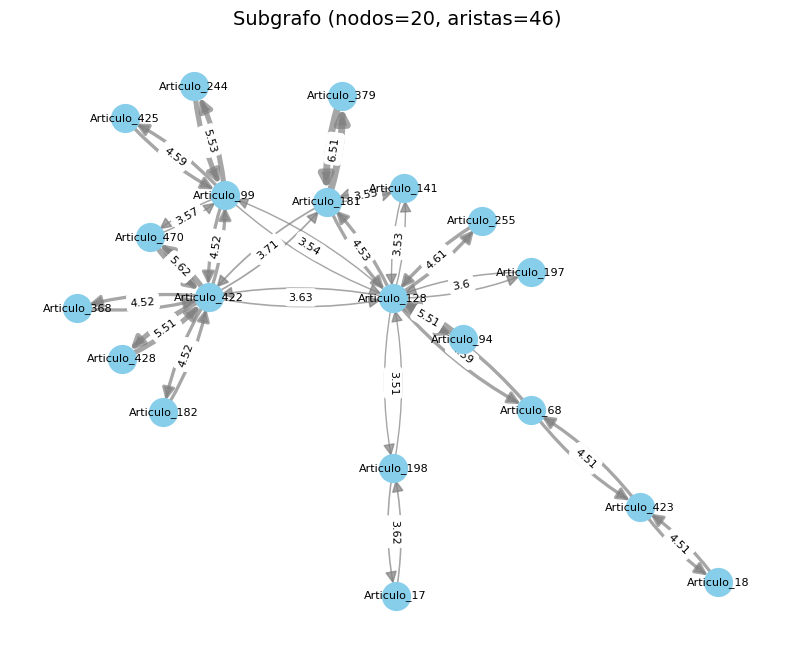

In [5]:
# Visualización del grafo (subgrafo de prueba) - nodos a partir de primeras aristas
import networkx as nx
import matplotlib.pyplot as plt

# --- Número objetivo de nodos a visualizar (cámbialo aquí si quieres otro límite) ---
target_nodes = 20  # <-- límite de nodos (antes estaba 20)

# --- Construir lista de nodos a partir de las primeras aristas del grafo ---
all_edges = list(G.edges(data=True))
if not all_edges:
    print('El grafo no tiene aristas.')
    # aún así intentamos visualizar los primeros target_nodes nodos (sin aristas)
    subgrafo_nodos = list(nodos.keys())[:target_nodes]
else:
    nodes_from_edges = []
    M = 200  # revisar primeras M aristas hasta reunir target_nodes nodos
    for (u, v, _) in all_edges[:M]:
        if u not in nodes_from_edges:
            nodes_from_edges.append(u)
        if v not in nodes_from_edges:
            nodes_from_edges.append(v)
        if len(nodes_from_edges) >= target_nodes:
            break
    subgrafo_nodos = nodes_from_edges[:target_nodes]

G_sub = G.subgraph(subgrafo_nodos).copy()
print('Nodos elegidos de aristas:', subgrafo_nodos)
print('Subgrafo: n_nodos =', G_sub.number_of_nodes(), ' n_aristas =', G_sub.number_of_edges())

# --- Posición de los nodos ---
pos = nx.spring_layout(G_sub, seed=42)

# --- Dibujar nodos ---
plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G_sub, pos, node_size=400, node_color='skyblue')

# --- Preparar lista de aristas (convertir a lista para poder iterarla varias veces) ---
edges = list(G_sub.edges(data=True))

if len(edges) == 0:
    print("No hay aristas en el subgrafo seleccionado. Intenta ampliar la selección de nodos.")
else:
    # extraer anchuras a partir de peso; normalizar para que sean visibles
    weights = [d.get('weight', 1.0) for (_, _, d) in edges]
    # normalización simple (para que no salgan muy finas o muy gruesas)
    min_w, max_w = min(weights), max(weights)
    if max_w == min_w:
        widths = [2.0 for _ in weights]
    else:
        widths = [1.0 + 4.0 * ((w - min_w) / (max_w - min_w)) for w in weights]  # entre 1 y 5

    # Dibujar aristas con flechas
    nx.draw_networkx_edges(
        G_sub, pos,
        edgelist=[(u, v) for (u, v, _) in edges],
        width=widths,
        alpha=0.7,
        edge_color='gray',
        arrows=True,
        arrowsize=18,
        connectionstyle='arc3,rad=0.1'  # para que flechas paralelas se vean mejor
    )

    # --- Mostrar pesos de las aristas como etiquetas (redondeadas a 2 decimales) ---
    try:
        edge_labels = {(u, v): round(d.get('weight', 1.0), 2) for (u, v, d) in edges}
        nx.draw_networkx_edge_labels(G_sub, pos, edge_labels=edge_labels, font_size=8, label_pos=0.5)
    except Exception as e:
        # Si algo falla con las etiquetas (por ejemplo sobreposición), lo reportamos pero no detenemos la visualización
        print('Advertencia al dibujar etiquetas de peso:', e)

# --- Dibujar etiquetas de nodos ---
nx.draw_networkx_labels(G_sub, pos, font_size=8)

plt.title(f"Subgrafo (nodos={len(G_sub.nodes())}, aristas={len(edges)})", fontsize=14)
plt.axis('off')
plt.show()


# Paso 6: Algoritmo de Dijkstra - Caminos Mínimos

Esta celda implementa el algoritmo de Dijkstra para encontrar caminos más cortos entre artículos.

## Conversión a Diccionario de Adyacencia

### Estructura:

```python
grafo_dict = {n: {} for n in G.nodes()}
for u, v, data in G.edges(data=True):
    grafo_dict.setdefault(u, {})[v] = data.get('weight', 1.0)
```

**Formato**:
```python
{
    'Articulo_0': {'Articulo_5': 4.5, 'Articulo_12': 3.8},
    'Articulo_5': {'Articulo_12': 4.2},
    ...
}
```

**Ventaja**: Acceso O(1) a vecinos y pesos

## Algoritmo de Dijkstra

### Implementación Manual:

```python
def dijkstra_manual(grafo, inicio):
    import math
    import heapq
    
    distancias = {n: math.inf for n in grafo}
    previos = {n: None for n in grafo}
    
    distancias[inicio] = 0.0
    heap = [(0.0, inicio)]
    
    while heap:
        d_u, u = heapq.heappop(heap)
        
        if d_u > distancias[u]:
            continue
        
        for v, peso in grafo.get(u, {}).items():
            nd = d_u + peso
            if nd < distancias[v]:
                distancias[v] = nd
                previos[v] = u
                heapq.heappush(heap, (nd, v))
    
    return distancias, previos
```

### Algoritmo Paso a Paso:

#### 1. Inicialización:

```python
distancias = {n: math.inf for n in grafo}
previos = {n: None for n in grafo}
distancias[inicio] = 0.0
```

**Estado inicial**:
- Distancia al nodo inicio: 0
- Distancia a todos los demás: ∞
- Sin nodos previos

#### 2. Heap de Prioridad:

```python
heap = [(0.0, inicio)]
```

**Estructura**: Lista de tuplas `(distancia, nodo)`

**Propiedad**: `heapq` mantiene el mínimo al frente

#### 3. Relajación de Aristas:

```python
for v, peso in grafo.get(u, {}).items():
    nd = d_u + peso
    if nd < distancias[v]:
        distancias[v] = nd
        previos[v] = u
        heapq.heappush(heap, (nd, v))
```

**Proceso**:
1. Para cada vecino `v` de `u`
2. Calcular nueva distancia: `distancia[u] + peso(u,v)`
3. Si es menor que la conocida, actualizar
4. Agregar al heap para procesar

### Complejidad:

**Tiempo**: O((V + E) log V)
- V = número de nodos
- E = número de aristas
- log V por operaciones de heap

**Espacio**: O(V)

## Reconstrucción de Camino

### Función:

```python
def reconstruir_camino(previos, inicio, destino):
    camino = []
    nodo = destino
    
    if previos.get(nodo) is None and nodo != inicio:
        return []
    
    while nodo is not None:
        camino.append(nodo)
        if nodo == inicio:
            break
        nodo = previos.get(nodo)
    
    return camino[::-1]
```

### Proceso:

1. Empezar desde destino
2. Retroceder por previos
3. Invertir camino para obtener inicio → destino

In [6]:
# --- Crear diccionario de adyacencia (dirigido) incluyendo todos los nodos ---
# Se preserva la dirección: grafo_dict[u][v] = peso para arista u -> v
grafo_dict = {n: {} for n in G.nodes()}
for u, v, data in G.edges(data=True):
    grafo_dict.setdefault(u, {})[v] = data.get('weight', 1.0)

# --- Dijkstra eficiente (heap) para grafos dirigidos ---
def dijkstra_manual(grafo, inicio):
    """
    grafo: dict[node] -> dict[neighbor] -> weight
    inicio: nodo desde donde calcular distancias
    Devuelve: (distancias, previos)
      - distancias: dict nodo -> distancia mínima (float or math.inf)
      - previos: dict nodo -> nodo previo en camino mínimo (o None)
    Esta implementación respeta la dirección de las aristas y asume pesos no negativos.
    """
    import math
    import heapq

    if inicio not in grafo:
        raise KeyError(f"Nodo inicio '{inicio}' no está en el grafo")

    distancias = {n: math.inf for n in grafo}
    previos = {n: None for n in grafo}

    distancias[inicio] = 0.0
    heap = [(0.0, inicio)]  # (dist, nodo)

    while heap:
        d_u, u = heapq.heappop(heap)
        # Si extraemos una distancia mayor a la conocida, la descartamos
        if d_u > distancias[u]:
            continue

        # Relajar aristas salientes de u
        for v, peso in grafo.get(u, {}).items():
            # Asegurarse de trabajar con float
            w = float(peso)
            nd = d_u + w
            if nd < distancias[v]:
                distancias[v] = nd
                previos[v] = u
                heapq.heappush(heap, (nd, v))

    return distancias, previos

# --- Reconstruir camino desde inicio hasta destino ---
def reconstruir_camino(previos, inicio, destino):
    """Reconstruye el camino desde inicio hasta destino usando el mapa previos.
    Si destino no es alcanzable, devuelve lista vacía.
    """
    camino = []
    nodo = destino
    # Si destino no tiene previo y no es el inicio, puede ser inalcanzable
    if previos.get(nodo) is None and nodo != inicio:
        return []
    while nodo is not None:
        camino.append(nodo)
        if nodo == inicio:
            break
        nodo = previos.get(nodo)
    return camino[::-1]

# --- Ejemplo de uso ---
inicio = 'Articulo_197'
destino = 'Articulo_428'

# Validar nodos
if inicio not in grafo_dict:
    print(f"Nodo inicio '{inicio}' no está en el grafo. Nodos disponibles: {len(grafo_dict)}")
else:
    distancias, previos = dijkstra_manual(grafo_dict, inicio)
    if destino not in distancias or distancias[destino] == float('inf'):
        print(f"El nodo destino '{destino}' NO es alcanzable desde '{inicio}'.")
        print(f"Distancia registrada: {distancias.get(destino, '---')}")
        camino = []
    else:
        camino = reconstruir_camino(previos, inicio, destino)

    print("Resultado Dijkstra (dirigido):")
    if camino:
        print("Camino más corto:")
        print(" → ".join(camino))
        print("Costo total:", distancias[destino])
    else:
        print("No hay camino desde", inicio, "hasta", destino)
        # Mostrar distancias parciales a los 10 nodos más cercanos (si útiles)
        import math
        reachable = [(n, d) for n, d in distancias.items() if d < math.inf]
        reachable.sort(key=lambda x: x[1])
        print('Nodos alcanzables (top 10):', reachable[:10])


Resultado Dijkstra (dirigido):
Camino más corto:
Articulo_197 → Articulo_128 → Articulo_422 → Articulo_428
Costo total: 12.743178188800812


# Paso 7: Algoritmo de Kosaraju - Componentes Fuertemente Conexos

Esta celda implementa el algoritmo de Kosaraju para encontrar componentes fuertemente conexos (SCC).

## Componentes Fuertemente Conexos (SCC)

### Definición:

Un **componente fuertemente conexo** es un subconjunto maximal de nodos donde:
- Cada nodo puede alcanzar a todos los demás
- Siguiendo la dirección de las aristas

**Ejemplo**:
```
A → B → C → A  (SCC de 3 nodos)
D → E          (No es SCC, E no alcanza D)
```

## Algoritmo de Kosaraju

### Tres Pasos Principales:

1. **DFS en grafo original** → Llenar pila por orden de finalización
2. **Invertir el grafo** → Revertir dirección de aristas
3. **DFS en grafo invertido** → Según orden de pila

## Implementación

### Paso 1: DFS (Depth-First Search)

```python
def dfs(grafo, nodo, visitado, pila=None, componente=None):
    visitado.add(nodo)
    
    if componente is not None:
        componente.add(nodo)
    
    for vecino in grafo.get(nodo, {}):
        if vecino not in visitado:
            dfs(grafo, vecino, visitado, pila, componente)
    
    if pila is not None:
        pila.append(nodo)
```

#### Parámetros:

| Parámetro | Tipo | Uso |
|-----------|------|-----|
| `grafo` | dict | Diccionario de adyacencia |
| `nodo` | str | Nodo actual |
| `visitado` | set | Nodos ya visitados |
| `pila` | list | Orden de finalización (opcional) |
| `componente` | set | Nodos del componente (opcional) |

### Paso 2: Invertir Grafo

```python
def invertir_grafo(grafo):
    grafo_inv = {n: {} for n in grafo}
    for u in grafo:
        for v in grafo[u]:
            grafo_inv[v][u] = grafo[u][v]
    return grafo_inv
```

**Proceso**: Para cada arista u→v, crear arista v→u

### Paso 3: Kosaraju Completo

```python
def kosaraju(grafo):
    # Paso 1: DFS para llenar pila
    visitado = set()
    pila = []
    
    for nodo in grafo:
        if nodo not in visitado:
            dfs(grafo, nodo, visitado, pila=pila)
    
    # Paso 2: Invertir grafo
    grafo_inv = invertir_grafo(grafo)
    
    # Paso 3: DFS en grafo invertido
    visitado.clear()
    scc = []
    
    while pila:
        nodo = pila.pop()
        if nodo not in visitado:
            componente = set()
            dfs(grafo_inv, nodo, visitado, componente=componente)
            scc.append(componente)
    
    return scc
```

### Complejidad:

**Tiempo**: O(V + E)
- Dos DFS completos
- Inversión de grafo

**Espacio**: O(V)
- Pila y conjuntos de visitados

In [7]:
# --- Kosaraju para Componentes Fuertemente Conexos ---
def dfs(grafo, nodo, visitado, pila=None, componente=None):
    visitado.add(nodo)
    if componente is not None:
        componente.add(nodo)
    for vecino in grafo.get(nodo, {}):
        if vecino not in visitado:
            dfs(grafo, vecino, visitado, pila, componente)
    if pila is not None:
        pila.append(nodo)

# --- Invertir el grafo ---
def invertir_grafo(grafo):
    grafo_invertido = {n: {} for n in grafo}
    for u, vecinos in grafo.items():
        for v in vecinos:
            grafo_invertido[v][u] = vecinos[v]  # conservar peso original
    return grafo_invertido

# --- Encontrar componentes fuertemente conexos ---
def componentes_fuertemente_conexos(grafo):
    visitado = set()
    pila = []

    # 1 DFS para llenar pila con orden de finalización
    for nodo in grafo:
        if nodo not in visitado:
            dfs(grafo, nodo, visitado, pila)

    # 2 Invertir grafo
    grafo_inv = invertir_grafo(grafo)

    # 3 DFS según orden inverso de finalización
    visitado.clear()
    scc = []
    while pila:
        nodo = pila.pop()
        if nodo not in visitado:
            componente = set()
            dfs(grafo_inv, nodo, visitado, componente=componente)
            scc.append(componente)
    return scc

# --- Usar el algoritmo en nuestro grafo ---
scc = componentes_fuertemente_conexos(grafo_dict)

# --- Mostrar estadísticas generales ---
print(f"Número total de componentes fuertemente conexas: {len(scc)}")
print("Primeras 5 componentes (pueden ser individuales):")
for comp in scc[:5]:
    print(comp)

# --- Filtrar componentes con más de 1 artículo ---
componentes_grandes = [c for c in scc if len(c) > 1]

# --- Ordenar por tamaño descendente ---
componentes_grandes.sort(key=lambda x: len(x), reverse=True)

# --- Mostrar los clusters más grandes ---
print(f"\nNúmero de componentes con más de 1 artículo: {len(componentes_grandes)}")
print("Primeras 5 componentes grandes (ordenadas por tamaño):")
for comp in componentes_grandes[:5]:
    print(f"Tamaño: {len(comp)} -> Artículos: {comp}")


Número total de componentes fuertemente conexas: 1
Primeras 5 componentes (pueden ser individuales):
{'Articulo_128', 'Articulo_197', 'Articulo_17', 'Articulo_99', 'Articulo_141', 'Articulo_181', 'Articulo_470', 'Articulo_428', 'Articulo_422', 'Articulo_198', 'Articulo_423', 'Articulo_425', 'Articulo_255', 'Articulo_379', 'Articulo_442', 'Articulo_182', 'Articulo_68', 'Articulo_368', 'Articulo_244', 'Articulo_18', 'Articulo_94'}

Número de componentes con más de 1 artículo: 1
Primeras 5 componentes grandes (ordenadas por tamaño):
Tamaño: 21 -> Artículos: {'Articulo_128', 'Articulo_197', 'Articulo_17', 'Articulo_99', 'Articulo_141', 'Articulo_181', 'Articulo_470', 'Articulo_428', 'Articulo_422', 'Articulo_198', 'Articulo_423', 'Articulo_425', 'Articulo_255', 'Articulo_379', 'Articulo_442', 'Articulo_182', 'Articulo_68', 'Articulo_368', 'Articulo_244', 'Articulo_18', 'Articulo_94'}
